Define a method to create a DWI signal using a single tensor

In [31]:
from dipy.core.gradients import gradient_table
from dipy.core.sphere import disperse_charges, HemiSphere, Sphere

def create_single_tensor_signal(_hsph_dirs, _evals, _evecs, _bval_shell, _S0, _snr):
    """Create a multi-tensor dMRI signal for simulation purposes. It adds a b0 volume."""

    # Create the gradient table placing random points on a hemisphere
    rng = np.random.default_rng(1234)
    theta = np.pi * rng.random(_hsph_dirs)
    phi = 2 * np.pi * rng.random(_hsph_dirs)
    hsph_initial = HemiSphere(theta=theta, phi=phi)

    # Move the points so that the electrostatic potential energy is minimized
    iterations = 5000
    hsph_updated, potential = disperse_charges(hsph_initial, iterations)
    # Create a sphere
    sph = Sphere(xyz=np.vstack((hsph_updated.vertices, -hsph_updated.vertices)))

    # Create the gradients
    vertices = sph.vertices
    values = np.ones(vertices.shape[0])
    bvecs = vertices
    bvals = _bval_shell * values

    # Add a b0 value to the gradient table
    bvecs = np.insert(bvecs, 0, np.array([0, 0, 0]), axis=0)
    bvals = np.insert(bvals, 0, 0)
    _gtab = gradient_table(bvals, bvecs)

    # Create the signal
    _signal = single_tensor(_gtab, S0=_S0, evals=_evals, evecs=_evecs, snr=_snr, rng=None)

    return _signal, _gtab

Create the DWI signal using a single tensor.

In [32]:
import numpy as np
from dipy.core.geometry import sphere2cart
from dipy.sims.voxel import single_tensor, all_tensor_evecs

# Polar coordinates (theta, phi) of the principal axis of the tensor
angles = np.array([0, 0])
sticks = np.array(sphere2cart(1, np.deg2rad(angles[0]), np.deg2rad(angles[1])))
evecs = all_tensor_evecs(sticks)

# Eigenvalues of the tensor
evals1 = [0.0015, 0.0003, 0.0003]

# Half the number of the gradient vectors
hsph_dirs = 90

# Single shell: b = 1000 s/mm^2
bval_shell = 1000

S0 = 100
# Noise-free signal
snr = None

signal, gtab = create_single_tensor_signal(hsph_dirs, evals1, evecs, bval_shell, S0, snr)

Define a method to plot the fODFs of the signal

In [33]:
from dipy.viz import window, actor

def plot_dwi_fodf(_odf, _sphere, background=(255, 255, 255)):

    scene = window.Scene()
    scene.SetBackground(background)
    
    odf_actor = actor.odf_slicer(_odf[None, None, None, :], sphere=_sphere, colormap="plasma")
    odf_actor.RotateX(90)
    
    scene.add(odf_actor)
    _scene_array = window.snapshot(scene, offscreen=True)

    return _scene_array

Plot the fODFs of the signal

We now define the Gaussian process model instance with a spherical kernel.

In [34]:
from eddymotion.model._dipy import GaussianProcessModel

kernel_model = "spherical"
lambda_s = 2.0
a = 1.0
sigma_sq = 0.5

gp_model = GaussianProcessModel(kernel_model=kernel_model, lambda_s=lambda_s, a=a, sigma_sq=sigma_sq)

We fit the Gaussian process with the diffusion-encoding gradient vectors: walk all directions leaving out one direction at a time from the training data and fit the Gaussian process. Predict on the direction that has been left out from the training data. The b0 volume is excluded from the computations.

In [35]:
y_pred = []
pred_x_idx = list(range(1, len(gtab.bvals)))
for idx in pred_x_idx:

    # Create the train mask
    # Exclude the 0 index (b0) as well
    loo = [0, idx]
    train_mask = np.ones(len(gtab.bvals), dtype=bool)
    train_mask[loo] = False
    gpfit = gp_model.fit(signal[train_mask], gtab[train_mask])

    # Predict the signal on the excluded diffusion-encoding gradient vector
    X_qry = gtab.bvecs[~train_mask][-1]
    _y_pred = gpfit.predict(X_qry[np.newaxis, :])

    # Check whether the hyperparameters of the kernel have been optimized
    # gp_model.kernel_

    y_pred.append(_y_pred.item())

/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter a is close to the specified upper bound 3.141592653589793. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/jhlegarreta/.virtualenvs/eddymotion/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter lambda_s is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may fi

Plot the training data and the predictions from the Gaussian process.

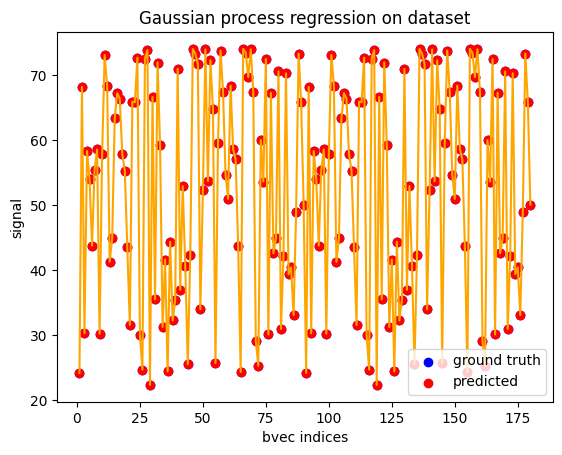

In [36]:
from matplotlib import pyplot as plt
%matplotlib inline

# There is only a single voxel in the simulated DWI signal, so we add 3 axes before the diffusion-encoding gradient axis to appropriately model the voxel.
voxel_idx = [0, 0, 0]
dwi_data = signal[np.newaxis, np.newaxis, np.newaxis, :]

# Exclude the b0s for the plot
y = dwi_data[voxel_idx[0], voxel_idx[1], voxel_idx[2], :][~gtab.b0s_mask]
x = np.asarray(range(len(gtab.bvals)))[~gtab.b0s_mask]

# Account for the fact that the query index is obtained in the [1, len(gtab)] range in the indices
_pred_x_idx = list(map(lambda _x: _x-1, pred_x_idx))
                   
fig, ax = plt.subplots()
ax.plot(x, y, c="orange")
plt.scatter(x, y, c="b", label="ground truth")
# plt.scatter(x[pred_x_idx], y_pred[pred_x_idx], c="r", label="predicted")
plt.scatter(x[_pred_x_idx], y_pred, c="r", label="predicted")
ax.set_xlabel("bvec indices")
ax.set_ylabel("signal")
ax.legend(loc="lower right")
plt.title("Gaussian process regression on dataset")

plt.show()